In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f

import torchvision
import torchvision.transforms as t

import sys

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data = np.loadtxt(open("/kaggle/input/mnist-train/mnist_train_small.csv", "rb"), delimiter=",")

data = data[:, 1:]

data_norm = data / np.max(data)
data_norm = 2*data_norm - 1

data_tensors = torch.FloatTensor(data_norm)

batch_size = 100

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(28*28, 256)
        
        self.fc2 = nn.Linear(256, 256)
        
        self.out = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = f.leaky_relu(x)
        
        x = self.fc2(x)
        x = f.leaky_relu(x)
        
        x = self.out(x)
        x = torch.sigmoid(x)
        
        return x
    
discriminator = Discriminator()

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(64, 256)
        
        self.fc2 = nn.Linear(256, 256)
        
        self.out = nn.Linear(256, 784)
        
    def forward(self, x):
        x = self.fc1(x)
        x = f.leaky_relu(x)
        
        x = self.fc2(x)
        x = f.leaky_relu(x)
        
        x = self.out(x)
        x = torch.tanh(x)
        
        return x

generator = Generator()

In [6]:
loss_fun = nn.BCELoss()

discriminator = discriminator.to(device)
generator = generator.to(device)

discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0003)
generator_optim = torch.optim.Adam(generator.parameters(), lr=0.0003)

In [7]:
num_epochs = 50000

losses = np.zeros((num_epochs, 2))
discriminator_decisions = np.zeros((num_epochs, 2))

for epoch in range(num_epochs):
    random_index = torch.randint(data_tensors.shape[0], (batch_size, ))
    real_images = data_tensors[random_index, :].to(device)
    fake_images = generator(torch.randn(batch_size, 64).to(device))
    
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    
    
    
    pred_real = discriminator(real_images)
    discriminator_loss_real = loss_fun(pred_real, real_labels)
    
    pred_fake = discriminator(fake_images)
    discriminator_loss_fake = loss_fun(pred_fake, fake_labels)
    
    discriminator_loss = discriminator_loss_fake + discriminator_loss_real
    losses[epoch, 0] = discriminator_loss.item()
    discriminator_decisions[epoch, 0] = torch.mean((pred_real > 0.5).float()).detach()
    
    discriminator_optim.zero_grad()
    discriminator_loss.backward()
    discriminator_optim.step()
    
    
    
    
    
    fake_images = generator(torch.randn(batch_size, 64).to(device))
    pred_fake = discriminator(fake_images)
    
    generator_loss = loss_fun(pred_fake, real_labels)
    losses[epoch, 1] = generator_loss.item()
    discriminator_decisions[epoch, 1] = torch.mean((pred_fake > 0.5).float()).detach()
    
    generator_optim.zero_grad()
    generator_loss.backward()
    generator_optim.step()
    
    if (epoch + 1)%500 == 0:
        mssg = f"Finished Epoch {epoch+1}/{num_epochs}"
        sys.stdout.write("\r" + mssg)

Finished Epoch 50000/50000

In [8]:
_, axis = plt.subplots(3, 1, figsize=(10, 15))

axis[0].plot(losses)
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_title("Model Loss")
axis[0].legend(["Discriminator, Generator"])

axis[1].plot(losses[::5, 0], losses[::5, 1], "k.", alpha=0.1)
axis[1].set_ylabel("Discriminator Loss")
axis[1].set_xlabel("Generator Loss")

axis[2].plot(discriminator_decisions)
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Probability (\"real\")")
axis[2].set_title("Discriminator Output")
axis[2].legend(["Real", "Fake"]);

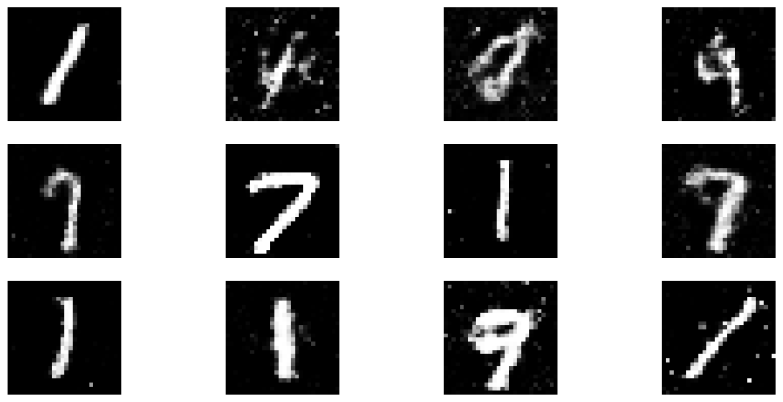

In [9]:
generator.eval()
fake_data = generator(torch.randn(12, 64).to(device)).cpu()

_, axis = plt.subplots(3, 4, figsize=(15, 7))
for i, ax in enumerate(axis.flatten()):
    ax.imshow(fake_data[i, :, ].detach().view(28, 28), cmap="gray")
    ax.axis("off")
plt.show()